In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product
from datetime import datetime
import json
from statannotations.Annotator import Annotator
from matplotlib.ticker import ScalarFormatter, NullFormatter

import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from scipy import stats
import gym

import matplotlib.colors as mcolors
import matplotlib as mpl

from joblib import Parallel, delayed
import multiprocessing

# create a color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000']
cmap = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs', hex_list)

def rgba_to_hex(rgba):
    return mcolors.rgb2hex(rgba)

def change_lightness(color, amount=0.5):
    """ amount can be between -1 and 1 """
    import colorsys
    try:
        c = mcolors.to_rgb(color)
        c = colorsys.rgb_to_hls(*c)
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    except ValueError:
        return color

def pvalue_to_stars(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return 'ns'

def pairedCohensD(x,y):
    """ Calculate the paired cohens d for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    return (np.mean(x-y) / np.std(x-y,ddof=1))

def cliffsDelta(x,y):
    """ Calculate the cliffs delta for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    prod = np.array(list(product(x,y)))
    diffs = np.int32(prod[:,0]<prod[:,1]) - np.int32(prod[:,0]>prod[:,1])
    return np.mean(diffs)

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def delta_to_effect(delta):
    """ Convert a cliffs delta to effect size """
    delta = np.abs(delta)
    if delta < 0.147:
        return 'neg'
    elif delta < 0.33:
        return '^'
    elif delta < 0.474:
        return '^^'
    elif delta > 0.474:
        return '^^^'
    else:
        return ''

def d_to_effect(d):
    """ Convert a Cohen's d to effect size """
    d = np.abs(d)
    if d < 0.2:
        return 'neg'
    elif d < 0.5:
        return '^'
    elif d < 0.8:
        return '^^'
    elif d > 0.8:
        return '^^^'
    else:
        return ''

def r_to_effect(r):
    """ Convert a rank biserial correlation to effect size according to Funder (2019)"""
    r = np.abs(r)
    if r < 0.1:
        return 'neg'
    elif r < 0.3:
        return '^'
    elif r < 0.4:
        return '^^'
    elif r > 0.4:
        return '^^^'
    else:
        return ''

## OCT VS MHO DATA

In [2]:
data_directory = '../../16FlYMaze/OCTvMCH_learning_16y/data/'

# Define File Exceptions
file_exceptions = []

# Define Non-functional Arenas (arenas that had leaks or were otherwise unusable)
arena_exceptions = [5,6,8,9,10,12,13,14,15]

In [3]:
files = list(filter(lambda v: np.all([i not in v for i in file_exceptions]) and os.path.isdir(data_directory+v),os.listdir(data_directory)))
arenas = list(filter(lambda v: np.all([i != v for i in arena_exceptions]),range(16)))

In [4]:
all_data_unfiltered = []

for i,folder in tqdm(product(arenas,files),total=len(arenas)*len(files)):
    try:
        with open(data_directory+f"{folder}/processed_data/fly_{i}.ydata", "r") as f:
            data = json.load(f)
            for d in data.keys():
                data[d] = np.array(data[d])
        with open(data_directory+f"{folder}/fly_{i}.yexperiment", "r") as f:
            experiment = json.load(f)
            data["fly_experiment"] = experiment["fly_experiment"]
            data["arena"] = i
            data["folder"] = folder
        all_data_unfiltered.append(data)
    except Exception as e:
        print(f"Failed to load data for fly {i} in folder {folder}. Error: {e}")

  0%|          | 0/42 [00:00<?, ?it/s]

Failed to load data for fly 0 in folder learning_test_2022-09-16_22-24. Error: [Errno 2] No such file or directory: '../../16FlYMaze/OCTvMCH_learning_16y/data/learning_test_2022-09-16_22-24/processed_data/fly_0.ydata'
Failed to load data for fly 1 in folder learning_test_2022-09-16_22-24. Error: [Errno 2] No such file or directory: '../../16FlYMaze/OCTvMCH_learning_16y/data/learning_test_2022-09-16_22-24/processed_data/fly_1.ydata'
Failed to load data for fly 2 in folder learning_test_2022-09-16_22-24. Error: [Errno 2] No such file or directory: '../../16FlYMaze/OCTvMCH_learning_16y/data/learning_test_2022-09-16_22-24/processed_data/fly_2.ydata'
Failed to load data for fly 4 in folder learning_test_2022-09-16_22-24. Error: [Errno 2] No such file or directory: '../../16FlYMaze/OCTvMCH_learning_16y/data/learning_test_2022-09-16_22-24/processed_data/fly_4.ydata'
Failed to load data for fly 4 in folder learning_test_2022-09-17_00-44. Error: [Errno 2] No such file or directory: '../../16FlY

In [5]:
# make a copy of the data
all_data = all_data_unfiltered.copy()
# filter data to only include flies that have completed at least 160 trials
all_data = list(filter(lambda v: v["trial_count"] >= 160,all_data))

# print all experiments
exps, invs, counts = np.unique([d["fly_experiment"] for d in all_data],return_counts=True,return_inverse=True)
for i in range(len(exps)):
    print(f"{exps[i]}: {counts[i]} flies")
exp_to_idx = {exps[i]:i for i in range(len(exps))}
idx_to_exp = {i:exps[i] for i in range(len(exps))}
# assign names to experiments
exp_names = ['MCH->OCT Training','OCT->MCH Training']

40xnaive_60xoct0-1_60xmch1-0.csv: 14 flies
40xnaive_60xoct1-0_60xmch0-1.csv: 14 flies


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


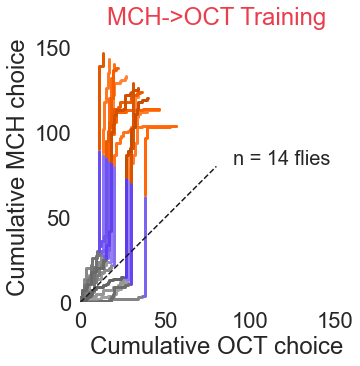

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


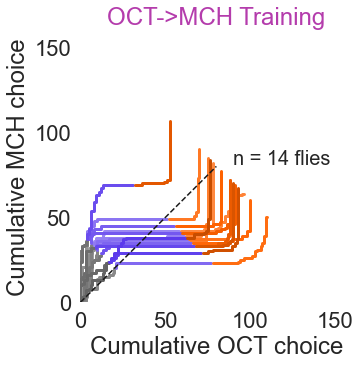

In [6]:
# plot all flies for each experiment
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # randomize order of flies
    np.random.shuffle(data)

    sns.set(font_scale=2)
    fig, ax = plt.subplots(figsize=(5,5))
    for i in range(len(data)):
        odor1_choice = np.cumsum(1-(data[i]['chosen_odor']-1))
        odor2_choice = np.cumsum(data[i]['chosen_odor']-1)

        exp = data[i]["fly_experiment"]
        scaler = 1 + (i/len(data) - 0.5)*0.5
        cval=0.25
        ax.plot(odor1_choice[:40], odor2_choice[:40], '-', color = change_lightness((0.5,0.5,0.5,1),scaler), alpha=1, linewidth=3)
        ax.plot(odor1_choice[40:100], odor2_choice[40:100], '-', color = change_lightness(cmap(cval),scaler), alpha=1, linewidth=3)
        ax.plot(odor1_choice[100:160], odor2_choice[100:160], '-', color = change_lightness(cmap(1-cval),scaler), alpha=1, linewidth=3)
        
    # add a text box with the number of flies
    textstr = f"n = {len(data)} flies"
    ax.text(90, 90, textstr, fontsize=20, verticalalignment='top')
    
    plt.box(False)
    ax.plot([0,80],[0,80], 'k--')
    ax.set_xlabel("Cumulative OCT choice")
    ax.set_ylabel("Cumulative MCH choice")
    limits = np.max([ax.get_xlim(),ax.get_ylim()])
    ax.set_xlim([0,160])
    ax.set_ylim([0,160])
    ax.set_title(exp_name, color = cmap(0.4) if exp_name == 'OCT->MCH Training' else cmap(0.6))
    ax.set_aspect('equal')
    alt_exp_name = exp_name.replace(' ','_').replace('->','_')
    plt.savefig(f"figures/Cumulative_Choice_{alt_exp_name}.pdf",bbox_inches='tight')
    
    plt.show()

In [7]:
data[0].keys()

dict_keys(['fly_positions', 'frame_times', 'current_arms', 'current_trial', 'current_reward_zone_status', 'chosen_arms', 'chosen_odor', 'reward_delivered', 'trial_start_times', 'trial_end_times', 'trial_odor_start_delay', 'time_spent_in_reward_zone', 'lengths_of_trials', 'odor_vectors', 'trial_baited', 'reward_states', 'start_arms', 'n_trials', 'max_frame_count', 'trial_count', 'experiment_states', 'reference_fly_positions', 'instantaneous_speed', 'instantaneous_motion_angle', 'instantaneous_upwind_speed', 'instantaneous_upwind_motion_angle', 'current_odor', 'encounter_trial_number', 'current_encounter', 'encounter_odor', 'encounter_durations', 'encounter_decisions', 'encounter_rewards', 'encounter_start_time', 'trial_odor_residence_times', 'rewarded_frames', 'trial_oriented_position', 'odor_oriented_position', 'fly_experiment', 'arena', 'folder'])

In [8]:
# plot all flies for each fly

# define logit function
def logit(x):
    x = (x+1)/2
    x = np.clip(x,1/160,1-(1/160))
    return np.log(x/(1-x))

dfs = []
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]

    folders = [d["folder"] for d in data]
    arenas = [d["arena"] for d in data]
    def get_CI(choices):
        choices = 2*(choices-1.5)
        return np.mean(choices)

    naive_CIs = np.array([get_CI(d['chosen_odor'][:40]) for d in data])
    Training_CIs = np.array([get_CI(d['chosen_odor'][40:100]) for d in data])
    reversal_CIs = np.array([get_CI(d['chosen_odor'][100:]) for d in data])
    if exp_name == 'MCH->OCT Training':
        df = pd.DataFrame(
            {
                'Naive':naive_CIs,
                'Training':Training_CIs,
                'Reversal':reversal_CIs,
                'Experiment':exp_name,
                'Arena':arenas,
                'Folder':folders,
                'OCT LI':logit(Training_CIs)-logit(reversal_CIs),
                'MCH LI':logit(Training_CIs)-logit(naive_CIs),
            }
        )
    else:
        df = pd.DataFrame(
            {
                'Naive':naive_CIs,
                'Training':Training_CIs,
                'Reversal':reversal_CIs,
                'Experiment':exp_name,
                'Arena':arenas,
                'Folder':folders,
                'OCT LI':logit(naive_CIs)-logit(Training_CIs),
                'MCH LI':logit(reversal_CIs)-logit(Training_CIs),
            }
        )
    dfs.append(df)

df = pd.concat(dfs) 
df = pd.melt(df, id_vars=['Experiment'], value_vars=['Naive','Training','Reversal'], var_name='Condition', value_name='Choice Index')

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


t = 3.69, p = 9.99e-04


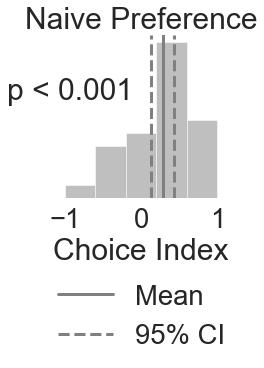

In [9]:
# plot a histogram of naive choice indices
sns.set(font_scale=2.5,style='white')
fig, ax = plt.subplots(figsize=(3,3))
plt.hist(df[df['Condition'] == 'Naive']['Choice Index'],bins=np.linspace(-1,1,6),color='gray',alpha=0.5)
# plot mean and 95% CI (bootstrap)
n_boot = 1000
boot_means = np.zeros(n_boot)
for i in range(n_boot):
    boot_means[i] = np.mean(np.random.choice(df[df['Condition'] == 'Naive']['Choice Index'],len(df[df['Condition'] == 'Naive']['Choice Index'])))
plt.axvline(np.mean(boot_means),color='gray',linewidth=3, label='Mean')
plt.axvline(np.percentile(boot_means,2.5),color='gray',linewidth=3,linestyle='--', label='95% CI')
plt.axvline(np.percentile(boot_means,97.5),color='gray',linewidth=3,linestyle='--')
# calculate one-sample t-test
t,p = stats.ttest_1samp(df[df['Condition'] == 'Naive']['Choice Index'],0)
print(f"t = {t:.2f}, p = {p:.2e}")
if p < 0.001:
    pstr = 'p < 0.001'
else:
    pstr = f'p = {p:.3f}'
plt.text(-0.3,0.6,pstr,transform=ax.transAxes)
plt.xlabel("Choice Index")
plt.xticks([-1,0,1])
plt.ylabel("")
plt.yticks([])
plt.title("Naive Preference")
plt.box(False)
plt.gca().spines['bottom'].set_visible(False)
plt.legend(frameon=False,bbox_to_anchor=(0.5, -1.0), loc='lower center', borderaxespad=0.)
plt.savefig("figures/OCt_MCH_Naive_Preference.pdf",bbox_inches='tight')
plt.show()


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calcu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

OCT->MCH Training_Training vs. OCT->MCH Training_Reversal: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
OCT->MCH Training_Naive vs. OCT->MCH Training_Training: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
MCH->OCT Training_Naive vs. MCH->OCT Training_Training: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
MCH->OCT Training_Training vs. MCH->OCT Training_Reversal: Wilcoxon test (paired samples), P_val:1.469e-03 Stat=0.000e+00
OCT->MCH Training_Naive vs. OCT->MCH Training_Reversal: Wilcoxon test (paired samples), P_val:4.028e-03 Stat=9.000e+00
MCH->OCT Training_Naive vs. MCH->OCT Training_Reversal: Wilcoxon test (paired samples), P_val:3.052e-03 Stat=8.000e+00


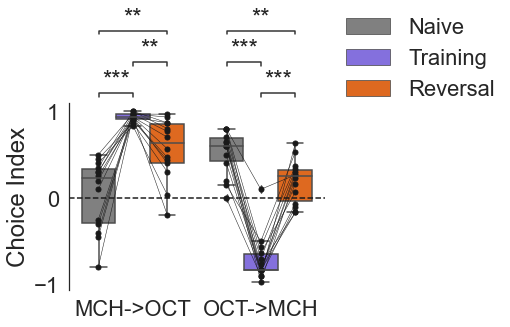

In [10]:
# make a paired boxplot of the data

sns.set(font_scale=2,style='white')
fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(x='Experiment',y='Choice Index',hue='Condition',data=df,ax=ax,palette=[(0.5,0.5,0.5,1),cmap(0.25),cmap(0.75)])
ax.plot([-0.27,0,0.27],[df[np.logical_and(df['Experiment']=='MCH->OCT Training',df['Condition']=='Naive')]['Choice Index'].values,
                    df[np.logical_and(df['Experiment']=='MCH->OCT Training',df['Condition']=='Training')]['Choice Index'].values,    
                    df[np.logical_and(df['Experiment']=='MCH->OCT Training',df['Condition']=='Reversal')]['Choice Index'].values],'-',color='k',marker='o',markersize=5,linewidth=0.5)
ax.plot([0.73,1,1.27],[df[np.logical_and(df['Experiment']=='OCT->MCH Training',df['Condition']=='Naive')]['Choice Index'].values,
                    df[np.logical_and(df['Experiment']=='OCT->MCH Training',df['Condition']=='Training')]['Choice Index'].values,
                    df[np.logical_and(df['Experiment']=='OCT->MCH Training',df['Condition']=='Reversal')]['Choice Index'].values],'-',color='k',marker='o',markersize=5,linewidth=0.5)
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)
ax.set_xlim([-0.5,1.5])
ax.set_ylabel('Choice Index')
ax.set_xlabel('')
ax.set_xticklabels(['MCH->OCT','OCT->MCH'])

# turn off all the spines except the left
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)

# add significance
pairs = [[('OCT->MCH Training','Naive'),('OCT->MCH Training','Training')],
            [('OCT->MCH Training','Naive'),('OCT->MCH Training','Reversal')],
            [('OCT->MCH Training','Training'),('OCT->MCH Training','Reversal')],
            [('MCH->OCT Training','Naive'),('MCH->OCT Training','Training')],
            [('MCH->OCT Training','Naive'),('MCH->OCT Training','Reversal')],
            [('MCH->OCT Training','Training'),('MCH->OCT Training','Reversal')]]

annotator = Annotator(ax, pairs, data=df, x='Experiment', y='Choice Index', hue='Condition')
annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
annotator.apply_and_annotate()

# draw horizontal lines at 0
ax.axhline(0, ls='--', color='k')

plt.tight_layout()
plt.savefig(f"figures/OCT-MCH_Choice_Index.pdf",bbox_inches='tight')
plt.show()

In [11]:
df = pd.concat(dfs)
df = pd.melt(df, id_vars=['Experiment'], value_vars=['OCT LI','MCH LI'], var_name='Condition', value_name='Learning Index')

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MCH LI_MCH->OCT Training vs. MCH LI_OCT->MCH Training: Mann-Whitney-Wilcoxon test two-sided, P_val:3.263e-02 U_stat=1.450e+02
OCT LI_MCH->OCT Training vs. OCT LI_OCT->MCH Training: Mann-Whitney-Wilcoxon test two-sided, P_val:1.647e-03 U_stat=2.900e+01
OCT LI_OCT->MCH Training vs. MCH LI_MCH->OCT Training: Mann-Whitney-Wilcoxon test two-sided, P_val:9.817e-01 U_stat=9.700e+01
OCT LI_MCH->OCT Training vs. MCH LI_OCT->MCH Training: Mann-Whitney-Wilcoxon test two-sided, P_val:1.478e-01 U_stat=6.600e+01


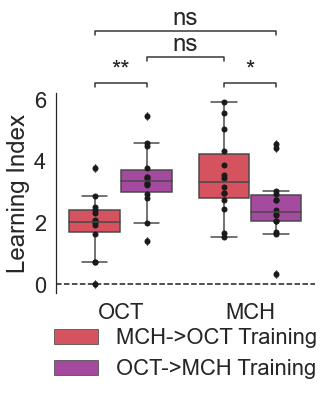

In [12]:
# make a paired boxplot of the data
sns.set(font_scale=2,style='white')
fig, ax = plt.subplots(figsize=(5,8))

sns.boxplot(x='Condition',y='Learning Index',hue='Experiment',data=df,ax=ax,palette=[cmap(0.6),cmap(0.4)])
ax.plot([-0.2,0.2],[df[np.logical_and(df['Experiment']=='MCH->OCT Training',df['Condition']=='OCT LI')]['Learning Index'].values,
                    df[np.logical_and(df['Experiment']=='OCT->MCH Training',df['Condition']=='OCT LI')]['Learning Index'].values],'o',color='k',markersize=5,linewidth=0.5)  
ax.plot([0.8,1.2],[df[np.logical_and(df['Experiment']=='MCH->OCT Training',df['Condition']=='MCH LI')]['Learning Index'].values,
                    df[np.logical_and(df['Experiment']=='OCT->MCH Training',df['Condition']=='MCH LI')]['Learning Index'].values],'o',color='k',markersize=5,linewidth=0.5)
# add legend at bottom
plt.legend(frameon=False, bbox_to_anchor=(0.5, -0.3), loc='center', borderaxespad=0.)
ax.set_xlim([-0.5,1.5])
ax.set_ylabel('Learning Index')
ax.set_xlabel('')
ax.set_xticklabels(['OCT','MCH'])

# turn off all the spines except the left
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)

# add significance
pairs = [[('OCT LI','MCH->OCT Training'),('OCT LI','OCT->MCH Training')],
            [('MCH LI','MCH->OCT Training'),('MCH LI','OCT->MCH Training')],
            [('OCT LI','OCT->MCH Training'),('MCH LI','MCH->OCT Training')],
            [('OCT LI','MCH->OCT Training'),('MCH LI','OCT->MCH Training')]]

annotator = Annotator(ax, pairs, data=df, x='Condition', y='Learning Index', hue='Experiment')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# draw horizontal lines at 0
ax.axhline(0, ls='--', color='k')

plt.tight_layout()
plt.savefig(f"figures/OCT-MCH_Learning_Index.pdf",bbox_inches='tight')
plt.show()

In [13]:
# perform a ANOVA to test for differences in learning index between the two experiments
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

df.columns = ['Order','Odor','Learning_Index']
model = anova_lm(ols('Learning_Index ~ C(Order) + C(Odor) + C(Order):C(Odor)', data=df).fit())
# save the results
model.to_csv('data/OCT-MCH_Learning_Index_ANOVA.csv')
model

df     sum_sq    mean_sq          F    PR(>F)
C(Order)           1.0   0.741423   0.741423   0.607563  0.439240
C(Odor)            1.0   1.690672   1.690672   1.385429  0.244538
C(Order):C(Odor)   1.0  21.399941  21.399941  17.536283  0.000109
Residual          52.0  63.456831   1.220324        NaN       NaN

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Early Naive vs. Late Naive: Wilcoxon test (paired samples), P_val:1.343e-02 Stat=1.400e+01
Late Naive vs. Early Training: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
Late Training vs. Early Reversal: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
Early Training vs. Late Training: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
Early Reversal vs. Late Reversal: Wilcoxon test (paired samples), P_val:4.028e-03 Stat=9.000e+00


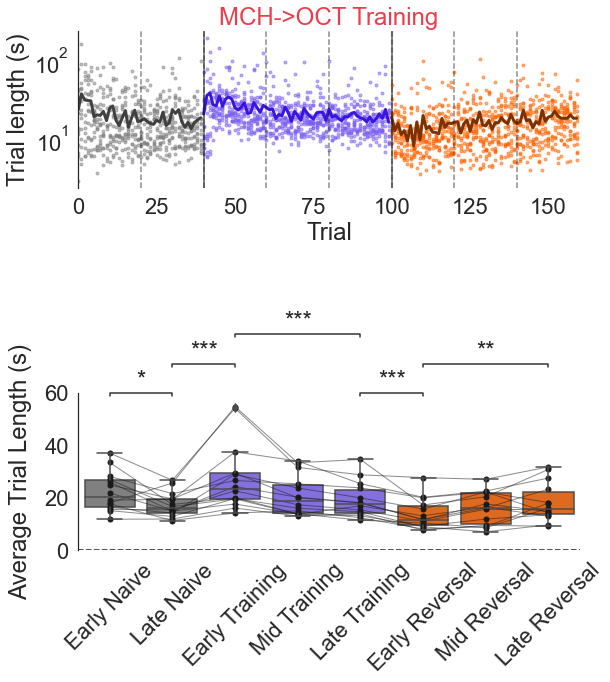

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Early Naive vs. Late Naive: Wilcoxon test (paired samples), P_val:5.016e-01 Stat=4.100e+01
Late Naive vs. Early Training: Wilcoxon test (paired samples), P_val:8.545e-04 Stat=4.000e+00
Late Training vs. Early Reversal: Wilcoxon test (paired samples), P_val:1.221e-03 Stat=5.000e+00
Early Training vs. Late Training: Wilcoxon test (paired samples), P_val:3.052e-03 Stat=8.000e+00
Early Reversal vs. Late Reversal: Wilcoxon test (paired samples), P_val:1.221e-03 Stat=5.000e+00


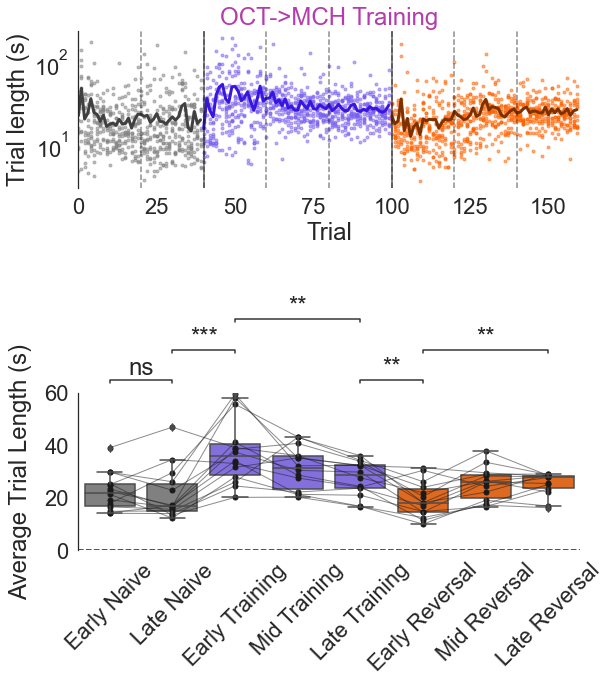

In [10]:
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get length of each trial
    length_of_trials = np.array([d['lengths_of_trials'] for d in data])

    names = ['Early Naive','Late Naive','Early Training','Mid Training','Late Training','Early Reversal','Mid Reversal','Late Reversal']
    avg_lengths = {}
    for name, i in zip(names,range(0,160,20)):
        avg_lengths[name] = [np.mean(d['lengths_of_trials'][i:i+20]) for d in data]

    df = pd.DataFrame(avg_lengths)
    df = pd.melt(df,var_name='Condition',value_name='Average Trial Length')

    sns.set(font_scale=2,style='white')
    fig, ax = plt.subplots(2,1,figsize=(9,10))

    for i in range(len(length_of_trials)):
        ax[0].plot(np.arange(0,40),length_of_trials[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),length_of_trials[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),length_of_trials[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(length_of_trials,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(length_of_trials,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(length_of_trials,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)


    ax[0].set_yscale('log')
    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("Trial length (s)")
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4))
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_lengths[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_lengths[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Trial Length',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['Early Naive','Late Naive'],['Late Naive','Early Training'],['Early Training','Late Training'],['Late Training','Early Reversal'],['Early Reversal','Late Reversal']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Trial Length')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    ax[1].set_ylim([0,60])
    ax[1].set_ylabel("Average Trial Length (s)", labelpad=12)
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.3)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    plt.savefig(f"figures/OCT-MCH_Trial_Lengths_{alt_exp_name}.pdf",bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:1.709e-03 Stat=6.000e+00
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
ER vs. LR: Wilcoxon test (paired samples), P_val:8.545e-04 Stat=4.000e+00


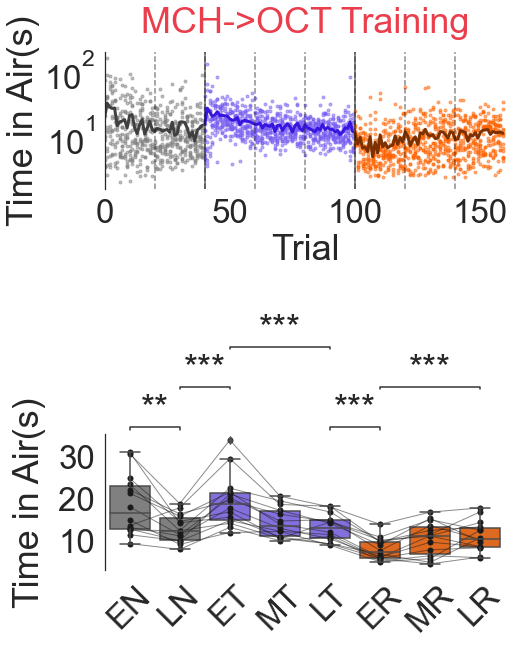

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:2.454e-02 Stat=1.700e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:2.319e-03 Stat=7.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:1.040e-01 Stat=2.600e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00


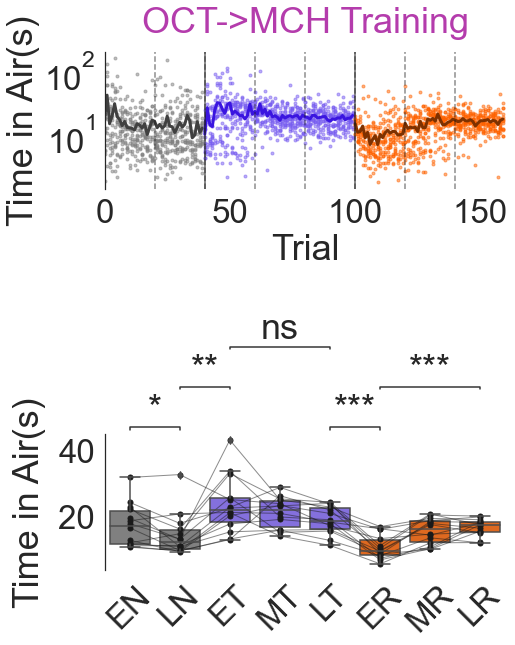

In [11]:
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get length of each trial
    length_of_trials = np.array([d['trial_odor_residence_times'][:160,0] for d in data])

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_lengths = {}
    for name, i in zip(names,range(0,160,20)):
        avg_lengths[name] = [np.mean(d['trial_odor_residence_times'][:160,0][i:i+20]) for d in data]

    df = pd.DataFrame(avg_lengths)
    df = pd.melt(df,var_name='Condition',value_name='Average Trial Length')

    sns.set(font_scale=3.0,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(length_of_trials)):
        ax[0].plot(np.arange(0,40),length_of_trials[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),length_of_trials[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),length_of_trials[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(length_of_trials,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(length_of_trials,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(length_of_trials,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)


    ax[0].set_yscale('log')
    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("Time in Air(s)")
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y=1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_lengths[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_lengths[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Trial Length',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Trial Length')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,60])
    ax[1].set_ylabel("Time in Air(s)", labelpad=12)
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    plt.savefig(f"figures/OCT-MCH_Time_in_Air_{alt_exp_name}.pdf", bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:5.798e-02 Stat=2.200e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:5.249e-03 Stat=1.000e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:1.709e-03 Stat=6.000e+00


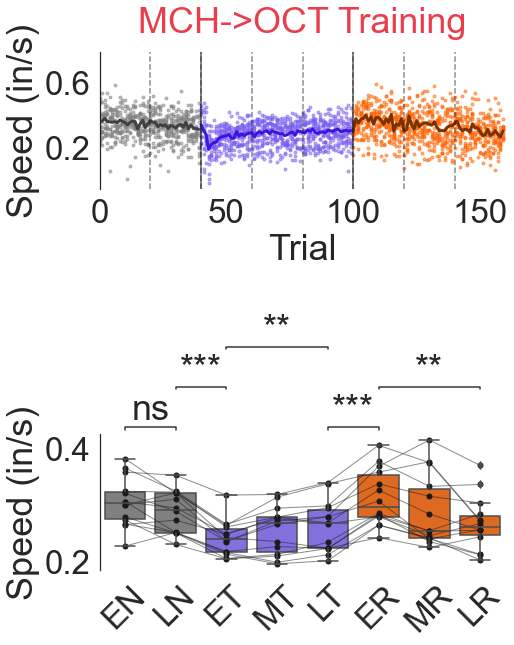

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:6.257e-01 Stat=4.400e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:8.077e-01 Stat=4.800e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00


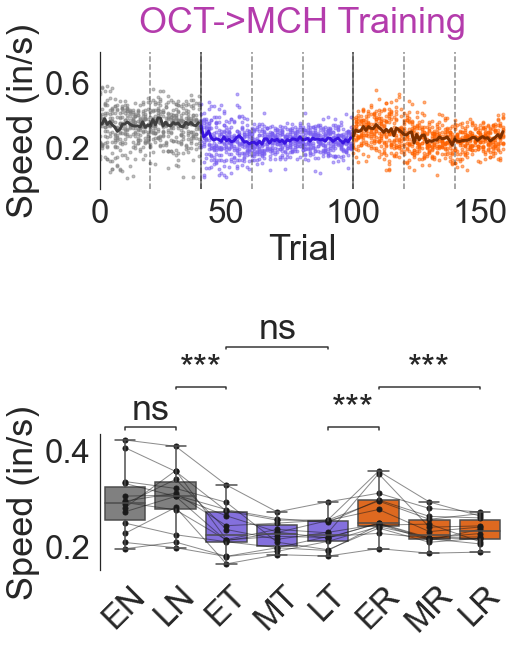

In [12]:
# get instantaenous speed per trial
def get_speed_per_trial(speed,trial):
    speed_per_trial = []
    for t in np.unique(trial):
        speed_per_trial.append(np.nanmean(speed[trial==t]))
    return np.array(speed_per_trial)

for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get length of each trial
    variable = np.array([get_speed_per_trial(d['instantaneous_speed'],np.clip(d['current_trial'],0,159)) for d in data])

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_var = {}
    for name, i in zip(names,range(0,160,20)):
        avg_var[name] = [np.mean(get_speed_per_trial(d['instantaneous_speed'],np.clip(d['current_trial'],0,159))[i:i+20]) for d in data]

    df = pd.DataFrame(avg_var)
    df = pd.melt(df,var_name='Condition',value_name='Average Variable')

    sns.set(font_scale=3.0,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(variable)):
        ax[0].plot(np.arange(0,40),variable[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),variable[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),variable[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(variable,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(variable,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(variable,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)


    ax[0].set_yscale('log')
    ax[0].set_ylim([0.1,1])
    ax[0].set_yticks([0.2,0.6])
    ax[0].set_yticklabels(['0.2','0.6'])
    ax[0].yaxis.set_major_formatter(ScalarFormatter())
    ax[0].yaxis.set_minor_formatter(NullFormatter())
    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("Speed (in/s)")
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y=1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_var[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_var[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Variable',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Variable')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,60])
    ax[1].set_ylabel("Speed (in/s)")
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    plt.savefig(f"figures/Average_Speed_{alt_exp_name}.pdf", bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Length of trial vs speed: 2.3279449590363953e-299
Air residence time vs trial length: 0.0


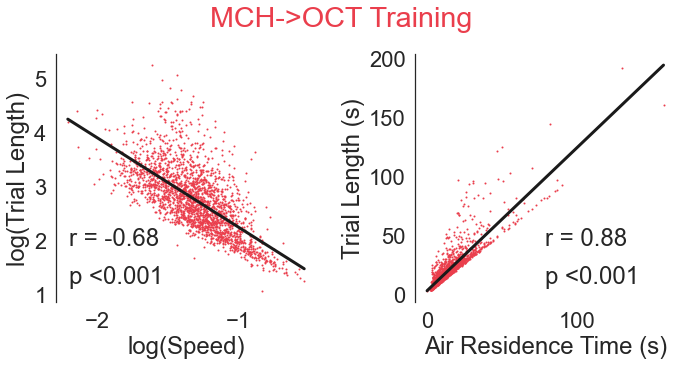

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Length of trial vs speed: 1.51724883503547e-182
Air residence time vs trial length: 0.0


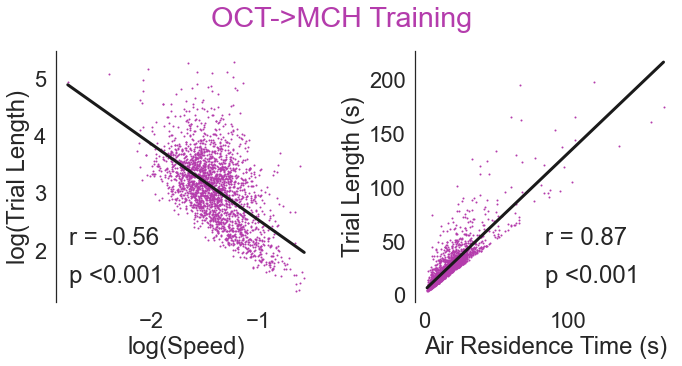

In [14]:
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get length of each trial
    length_of_trials = np.array([d['lengths_of_trials'] for d in data])
    # get instantaneous speed
    speed = np.array([get_speed_per_trial(d['instantaneous_speed'],np.clip(d['current_trial'],0,159)) for d in data])
    # get air residence time
    air_residence_time = np.array([d['trial_odor_residence_times'][:160,0] for d in data])

    # correlation analysis
    # length of trial vs speed

    x = np.log(speed.flatten())
    y = np.log(length_of_trials.flatten())
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    corr, p = stats.pearsonr(x,y)

    sns.set(font_scale=2,style='white')
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].scatter(x,y, s=1, color=cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4))
    ax[0].plot(np.sort(x),np.sort(x)*slope+intercept, color='k', linewidth=3)
    ax[0].set_xlabel("log(Speed)")
    ax[0].set_ylabel("log(Trial Length)")
    ax[0].text(0.05,0.30,f"r = {corr:.2f}", transform=ax[0].transAxes, ha='left', va='top')
    if p < 0.001:
        pstr = "p <0.001"
    else:
        pstr = f" = {p:.3f}"
    print(f"Length of trial vs speed: {p}")
    ax[0].text(0.05,0.15,pstr, transform=ax[0].transAxes, ha='left', va='top')

    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    # air residence time vs trial length
    x = air_residence_time.flatten()
    y = length_of_trials.flatten()
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    corr, p = stats.pearsonr(x,y)
    
    ax[1].scatter(x,y, s=1, color=cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4))
    ax[1].plot(np.sort(x),np.sort(x)*slope+intercept, color='k', linewidth=3)
    ax[1].set_xlabel("Air Residence Time (s)")
    ax[1].set_ylabel("Trial Length (s)")
    ax[1].text(0.5,0.30,f"r = {corr:.2f}", transform=ax[1].transAxes, ha='left', va='top')
    if p < 0.001:
        pstr = "p <0.001"
    else:
        pstr = f" = {p:.3f}"
    print(f"Air residence time vs trial length: {p}")
    ax[1].text(0.5,0.15,pstr, transform=ax[1].transAxes, ha='left', va='top')

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    # super title with padding
    plt.suptitle(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y=1.05)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    plt.savefig(f"figures/Correlation_{alt_exp_name}.pdf", bbox_inches='tight')
    plt.show()







c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:9.032e-01 Stat=5.000e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.709e-03 Stat=6.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:3.528e-02 Stat=1.900e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:2.441e-04 Stat=1.000e+00


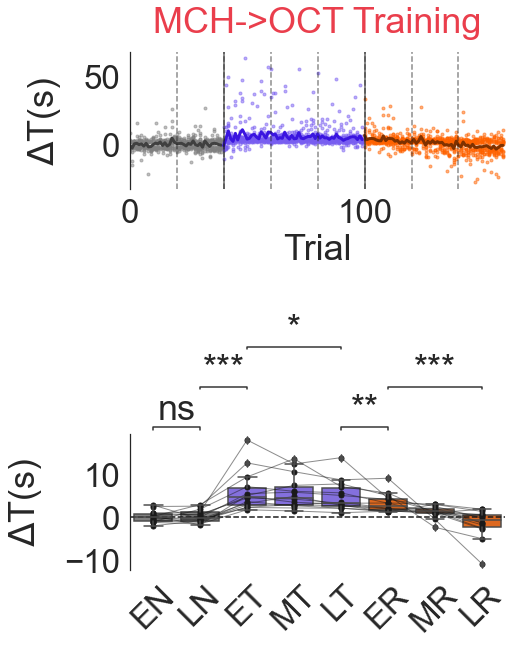

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:5.416e-01 Stat=4.200e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:3.662e-04 Stat=2.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:3.052e-03 Stat=8.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:2.958e-01 Stat=3.500e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00


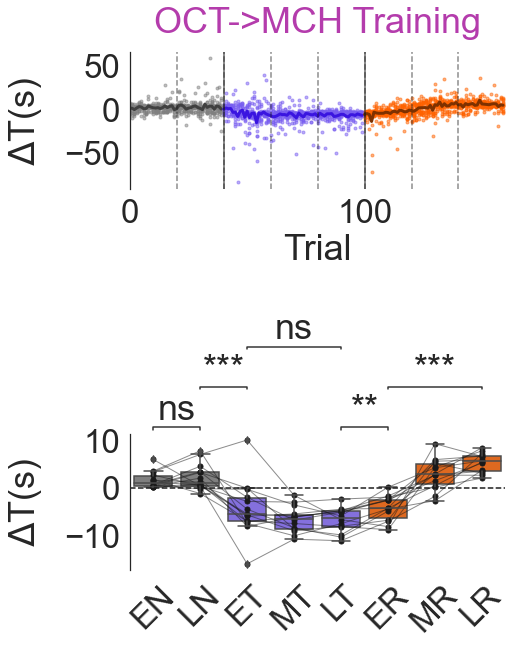

In [18]:
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get length of each trial
    length_of_trials = np.array([d['trial_odor_residence_times'][:160,2]-d['trial_odor_residence_times'][:160,1] for d in data])

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_lengths = {}
    for name, i in zip(names,range(0,160,20)):
        avg_lengths[name] = [np.mean((d['trial_odor_residence_times'][:160,2]-d['trial_odor_residence_times'][:160,1])[i:i+20]) for d in data]

    df = pd.DataFrame(avg_lengths)
    df = pd.melt(df,var_name='Condition',value_name='Average Trial Length')

    sns.set(font_scale=3,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(length_of_trials)):
        ax[0].plot(np.arange(0,40),length_of_trials[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),length_of_trials[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),length_of_trials[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(length_of_trials,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(length_of_trials,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(length_of_trials,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)

    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel(r"$\Delta$T(s)", labelpad=20)
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y=1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_lengths[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_lengths[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Trial Length',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Trial Length')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,60])
    ax[1].set_ylabel(r"$\Delta$T(s)", labelpad=20)
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    plt.savefig(f"figures/OCT-MCH_Time_Difference_{alt_exp_name}.pdf", bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:8.077e-01 Stat=4.800e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.343e-02 Stat=1.400e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:5.416e-01 Stat=4.200e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:1.221e-03 Stat=5.000e+00


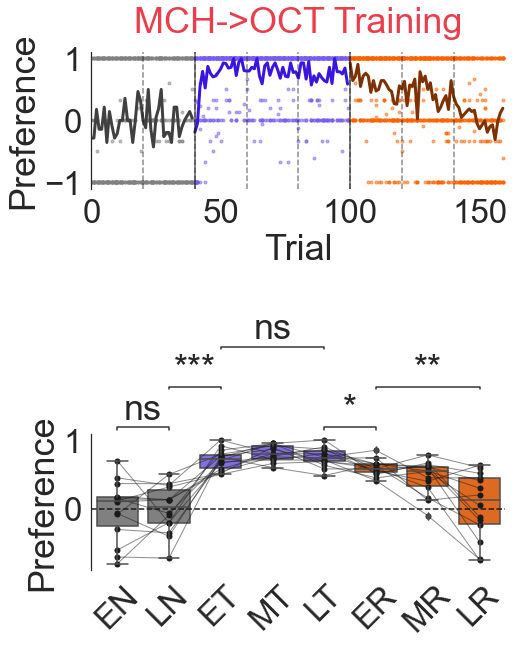

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:3.910e-01 Stat=3.800e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:3.662e-04 Stat=2.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.343e-02 Stat=1.400e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:2.319e-03 Stat=7.000e+00
ER vs. LR: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00


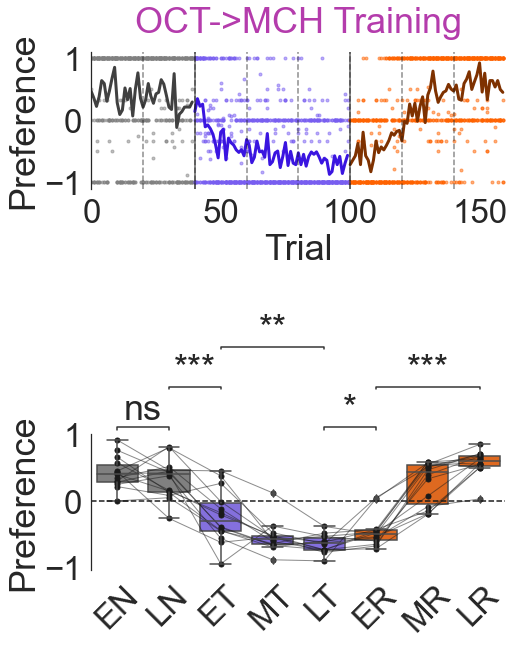

In [19]:
def get_encounter_preference(trial_number, odor):
    vals = []
    for t in range(0,max(trial_number)+1):
        v = odor[trial_number==t]
        v = v[v!=0]
        vals.append((np.sum(v==2)-np.sum(v==1))/np.sum(v!=0))
    return np.array(vals)

for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    variable = np.array([get_encounter_preference(d["encounter_trial_number"],d["encounter_odor"])[:160] for d in data])
    

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_var = {}
    for name, i in zip(names,range(0,160,20)):
        avg_var[name] = [np.mean(get_encounter_preference(d["encounter_trial_number"],d["encounter_odor"])[i:i+20]) for d in data]

    df = pd.DataFrame(avg_var)
    df = pd.melt(df,var_name='Condition',value_name='Average Variable')

    sns.set(font_scale=3,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(variable)):
        ax[0].plot(np.arange(0,40),variable[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),variable[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),variable[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(variable,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(variable,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(variable,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)

    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("Preference")
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4),y=1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_var[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_var[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Variable',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Variable')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,60])
    ax[1].set_ylabel("Preference")
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    plt.savefig(f"figures/Entry_Preference_{alt_exp_name}.pdf", bbox_inches='tight')
    plt.show()

C:\Users\labadmin\AppData\Local\Temp\ipykernel_3084\1363425815.py:10: RuntimeWarning: Mean of empty slice
  speed_per_trial.append(np.nanmean(speed_[trial==t]))
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:6.763e-02 Stat=2.300e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-03 Stat=5.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:2.958e-01 Stat=3.500e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:5.016e-01 Stat=4.100e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:4.028e-03 Stat=9.000e+00


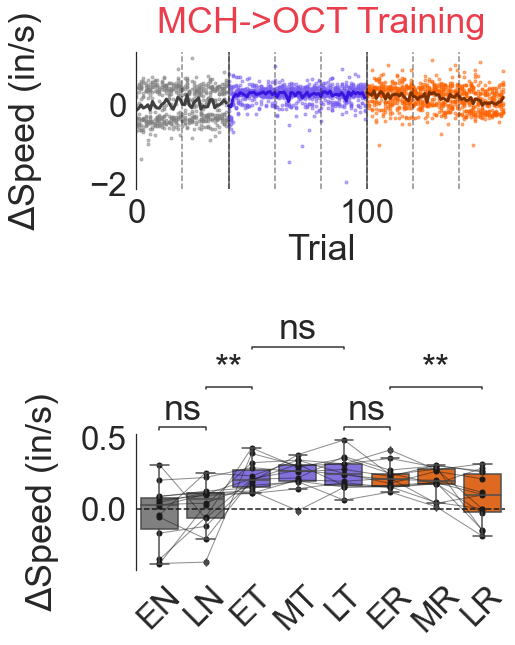

C:\Users\labadmin\AppData\Local\Temp\ipykernel_3084\1363425815.py:10: RuntimeWarning: Mean of empty slice
  speed_per_trial.append(np.nanmean(speed_[trial==t]))
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:8.552e-01 Stat=4.900e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:2.441e-04 Stat=1.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:8.552e-01 Stat=4.900e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:6.714e-03 Stat=1.100e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00


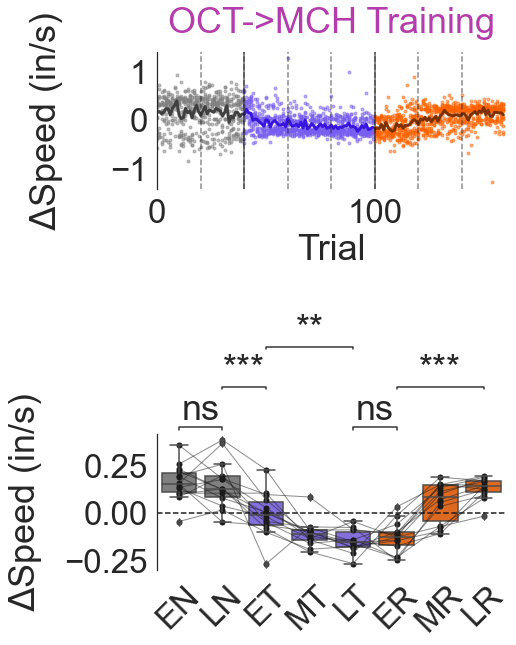

In [20]:
# get instantanenous speed per trial in specific odor
def get_speed_per_trial(speed,trial,odors,filter_odor):
    speed_per_trial = []
    for t in np.unique(trial):
        if t>=160:
            continue
        speed_ = speed.copy()
        speed_[odors!=filter_odor] = np.nan
        try:
            speed_per_trial.append(np.nanmean(speed_[trial==t]))
        except:
            speed_per_trial.append(0)
    return np.nan_to_num(np.array(speed_per_trial),0)

for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get length of each trial
    variable = np.array([get_speed_per_trial(d['instantaneous_speed'],np.clip(d['current_trial'],0,np.inf),d['current_odor'],2)[:160] - get_speed_per_trial(d['instantaneous_speed'],np.clip(d['current_trial'],0,np.inf),d['current_odor'],1)[:160] for d in data])
    

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_var = {}
    for name, i in zip(names,range(0,160,20)):
        avg_var[name] = [np.mean((get_speed_per_trial(d['instantaneous_speed'],d['current_trial'],d['current_odor'],2)[:160] - get_speed_per_trial(d['instantaneous_speed'],np.clip(d['current_trial'],0,np.inf),d['current_odor'],1)[:160])[i:i+20]) for d in data]

    df = pd.DataFrame(avg_var)
    df = pd.melt(df,var_name='Condition',value_name='Average Variable')

    sns.set(font_scale=3,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(variable)):
        ax[0].plot(np.arange(0,40),variable[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),variable[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),variable[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(variable,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(variable,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(variable,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)

    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel(r"$\Delta$Speed (in/s)", labelpad=45)
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y=1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_var[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_var[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Variable',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Variable')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,60])
    ax[1].set_ylabel(r"$\Delta$Speed (in/s)",labelpad=20)
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    plt.savefig(f"figures/Diff_Speed_{alt_exp_name}.pdf", bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:3.046e-01 Stat=1.750e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:6.999e-01 Stat=4.000e+01
LT vs. ER: Wilcoxon test (paired samples), P_val:9.164e-01 Stat=4.400e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:1.206e-02 Stat=7.000e+00
ER vs. LR: Wilcoxon test (paired samples), P_val:5.830e-01 Stat=4.300e+01


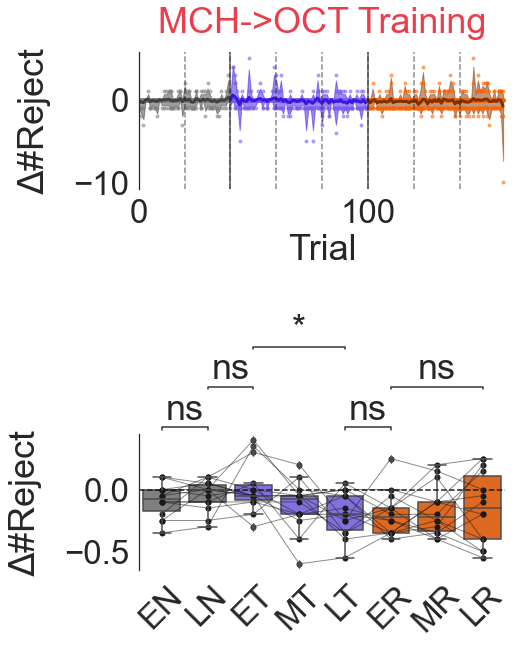

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:3.910e-01 Stat=3.800e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:8.552e-01 Stat=4.950e+01
LT vs. ER: Wilcoxon test (paired samples), P_val:9.165e-01 Stat=4.400e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:2.454e-02 Stat=1.750e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:2.441e-04 Stat=1.000e+00


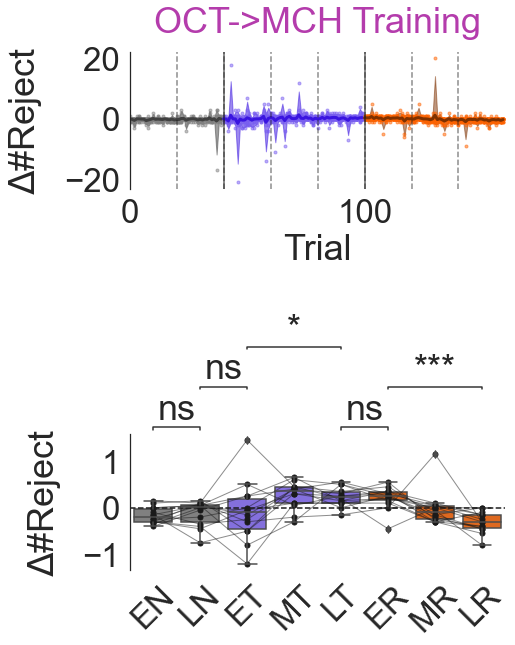

In [17]:
# get number of encounters per trial
def get_counts_per_trial(data,n_trials):
    per_trial = np.zeros(int(n_trials)+1)
    trials,counts = np.unique(data,return_counts=True)
    trials = trials.astype(int)
    per_trial[trials] = counts
    return per_trial

for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get numnber of encounters per trial
    odor_encounter_counts = np.array([get_counts_per_trial(np.clip(d['encounter_trial_number'],0,np.inf)[np.logical_and(d['encounter_odor']==2,d['encounter_decisions']!=1)],160) \
                                        - get_counts_per_trial(np.clip(d['encounter_trial_number'],0,np.inf)[np.logical_and(d['encounter_odor']==1,d['encounter_decisions']!=1)],160) for d in data])

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_counts = {}
    for name, i in zip(names,range(0,160,20)):
        avg_counts[name] = [np.mean((get_counts_per_trial(np.clip(d['encounter_trial_number'],0,np.inf)[np.logical_and(d['encounter_odor']==2,d['encounter_decisions']!=1)],160) \
                                        - get_counts_per_trial(np.clip(d['encounter_trial_number'],0,np.inf)[np.logical_and(d['encounter_odor']==1,d['encounter_decisions']!=1)],160))[i:i+20]) for d in data]

    df = pd.DataFrame(avg_counts)
    df = pd.melt(df,var_name='Condition',value_name='Average Number of Odor Rejections')

    sns.set(font_scale=3,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(odor_encounter_counts)):
        ax[0].plot(np.arange(0,40),odor_encounter_counts[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),odor_encounter_counts[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),odor_encounter_counts[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(odor_encounter_counts,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(odor_encounter_counts,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(odor_encounter_counts,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # add 95% percentile
    ax[0].fill_between(np.arange(0,40),np.percentile(odor_encounter_counts,2.5,axis=0)[:40],np.percentile(odor_encounter_counts,97.5,axis=0)[:40],color=change_lightness((0.5,0.5,0.5),1.5),alpha=0.5)
    ax[0].fill_between(np.arange(40,100),np.percentile(odor_encounter_counts,2.5,axis=0)[40:100],np.percentile(odor_encounter_counts,97.5,axis=0)[40:100],color=change_lightness(cmap(0.25),1.5),alpha=0.5)
    ax[0].fill_between(np.arange(100,160),np.percentile(odor_encounter_counts,2.5,axis=0)[100:160],np.percentile(odor_encounter_counts,97.5,axis=0)[100:160],color=change_lightness(cmap(0.75),1.5),alpha=0.5)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)


    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel(r"$\Delta$#Reject", labelpad=20)
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y =1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_counts[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_counts[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Number of Odor Rejections',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Number of Odor Rejections')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,5])
    ax[1].set_ylabel(r"$\Delta$#Reject", labelpad=20)
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    plt.savefig(f"figures/Diff_Rejections_{alt_exp_name}.pdf",bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


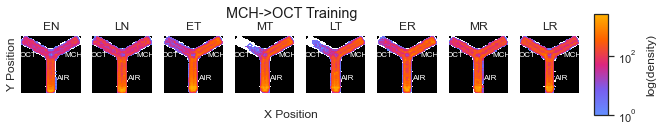

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


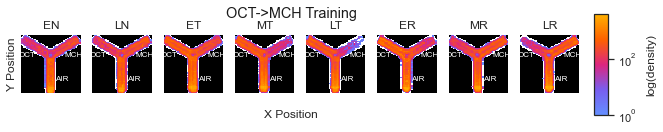

In [22]:
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]

    sns.set(font_scale=1,style='white')
    fig, ax = plt.subplots(1,8,figsize=(10,2),sharex=True,sharey=True)

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']

    for n,i in enumerate(range(0,160,20)):
        positions_cleaned = []
        trials_cleaned = []
        for d in data:
            positions = d['odor_oriented_position']
            trials = d['current_trial']
            
            # remove NaNs
            pc = positions[~np.any(np.isnan(positions),axis=1)].copy()
            tc = trials[~np.any(np.isnan(positions),axis=1)].copy()

            positions_cleaned.append(pc)
            trials_cleaned.append(tc)

        positions_cleaned = np.concatenate(positions_cleaned)
        trials_cleaned = np.concatenate(trials_cleaned)
        
        # draw a 2D histogram of the positions with zero set to alpha=0    

        background_hist = ax[n].hist2d(positions_cleaned[:,0],positions_cleaned[:,1],bins=50,cmap='Greys_r',vmax=1)

        # filter for only the portion of the experiment
        positions_cleaned = positions_cleaned[np.logical_and(trials_cleaned>=i,trials_cleaned<i+20),:]

        hist = ax[n].hist2d(positions_cleaned[:,0],positions_cleaned[:,1],bins=50,cmin=1,cmap=cmap,norm=mpl.colors.LogNorm())
        
        # turn off the spines
        ax[n].spines['top'].set_visible(False)
        ax[n].spines['right'].set_visible(False)
        ax[n].spines['bottom'].set_visible(False)
        ax[n].spines['left'].set_visible(False)

        # set equal aspect ratio
        ax[n].set_aspect('equal')
        ax[n].set_xlim([np.min(positions_cleaned[:,0]),np.max(positions_cleaned[:,0])])

        # turn off the ticks
        ax[n].set_xticks([])
        ax[n].set_yticks([])

        # set title
        ax[n].set_title(names[n])

        # add white text for odor zones
        ax[n].text(-0.6,0.,'OCT',color='white',horizontalalignment='center',verticalalignment='center',fontsize=8)
        ax[n].text(0.6,0.,'MCH',color='white',horizontalalignment='center',verticalalignment='center',fontsize=8)
        ax[n].text(0.3,-0.6,'AIR',color='white',horizontalalignment='center',verticalalignment='center',fontsize=8)


    ax[0].set_ylabel("Y Position")
    # add a central x label
    fig.text(0.5, 0.15, 'X Position', ha='center', va='center')

    # add a colorbar to the right
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(hist[3], cax=cbar_ax)
    cbar.set_label("log(density)",labelpad=10)

    # add super title
    fig.suptitle(exp_name, y=0.9, color='k')
    alt_exp_name = exp_name.replace(' ','_').replace('->','_')
    plt.savefig(f"figures/Position_Hist_{alt_exp_name}.pdf",bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:3.565e-02 Stat=9.500e+00
LN vs. ET: Wilcoxon test (paired samples), P_val:3.812e-01 Stat=3.300e+01
LT vs. ER: Wilcoxon test (paired samples), P_val:3.850e-01 Stat=1.900e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:1.157e-01 Stat=1.550e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:6.175e-02 Stat=1.200e+01


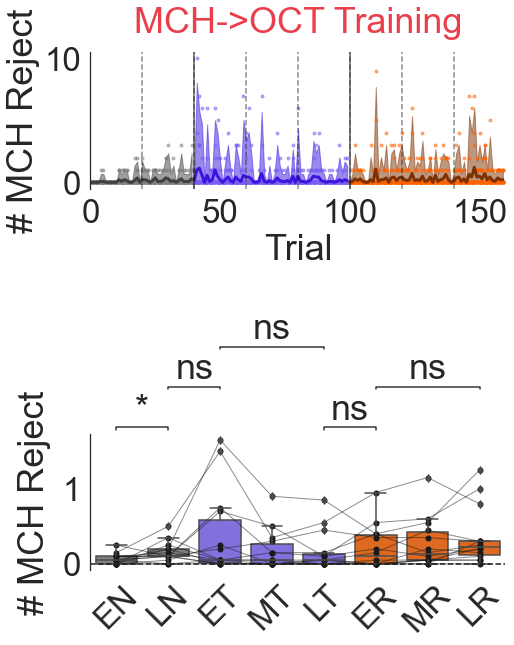

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:2.599e-03 Stat=2.500e+00
LN vs. ET: Wilcoxon test (paired samples), P_val:6.714e-03 Stat=1.100e+01
LT vs. ER: Wilcoxon test (paired samples), P_val:6.093e-01 Stat=3.250e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:3.305e-02 Stat=1.500e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:5.249e-03 Stat=1.000e+01


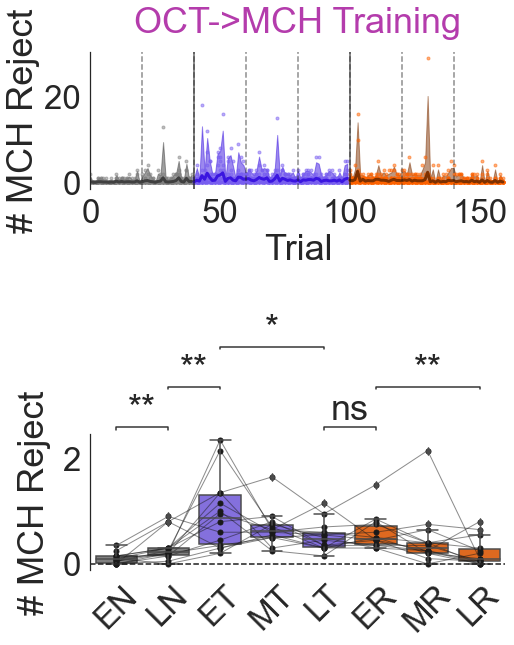

In [23]:
# get number of encounters per trial
def get_counts_per_trial(data,n_trials):
    per_trial = np.zeros(int(n_trials)+1)
    trials,counts = np.unique(data,return_counts=True)
    trials = trials.astype(int)
    per_trial[trials] = counts
    return per_trial

for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get numnber of encounters per trial
    odor_encounter_counts = np.array([get_counts_per_trial(np.clip(d['encounter_trial_number'],0,np.inf)[np.logical_and(d['encounter_odor']==2,d['encounter_decisions']!=1)],160) for d in data])

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_counts = {}
    for name, i in zip(names,range(0,160,20)):
        avg_counts[name] = [np.mean(get_counts_per_trial(np.clip(d['encounter_trial_number'],0,np.inf)[np.logical_and(d['encounter_odor']==2,d['encounter_decisions']!=1)],160)[i:i+20]) for d in data]

    df = pd.DataFrame(avg_counts)
    df = pd.melt(df,var_name='Condition',value_name='Average Number of Odor Rejections')

    sns.set(font_scale=3,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(odor_encounter_counts)):
        ax[0].plot(np.arange(0,40),odor_encounter_counts[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),odor_encounter_counts[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),odor_encounter_counts[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(odor_encounter_counts,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(odor_encounter_counts,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(odor_encounter_counts,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # add 95% percentile
    ax[0].fill_between(np.arange(0,40),np.percentile(odor_encounter_counts,2.5,axis=0)[:40],np.percentile(odor_encounter_counts,97.5,axis=0)[:40],color=change_lightness((0.5,0.5,0.5),1.5),alpha=0.5)
    ax[0].fill_between(np.arange(40,100),np.percentile(odor_encounter_counts,2.5,axis=0)[40:100],np.percentile(odor_encounter_counts,97.5,axis=0)[40:100],color=change_lightness(cmap(0.25),1.5),alpha=0.5)
    ax[0].fill_between(np.arange(100,160),np.percentile(odor_encounter_counts,2.5,axis=0)[100:160],np.percentile(odor_encounter_counts,97.5,axis=0)[100:160],color=change_lightness(cmap(0.75),1.5),alpha=0.5)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)


    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("# MCH Reject")
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4),y=1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_counts[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_counts[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Number of Odor Rejections',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Number of Odor Rejections')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,5])
    ax[1].set_ylabel("# MCH Reject", labelpad=12)
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    # plt.savefig(f"figures/MCH_Rejections_{alt_exp_name}.pdf",bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:2.345e-01 Stat=2.850e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:3.259e-01 Stat=2.650e+01
LT vs. ER: Wilcoxon test (paired samples), P_val:6.698e-01 Stat=4.550e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:9.442e-01 Stat=4.450e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:6.257e-01 Stat=4.400e+01


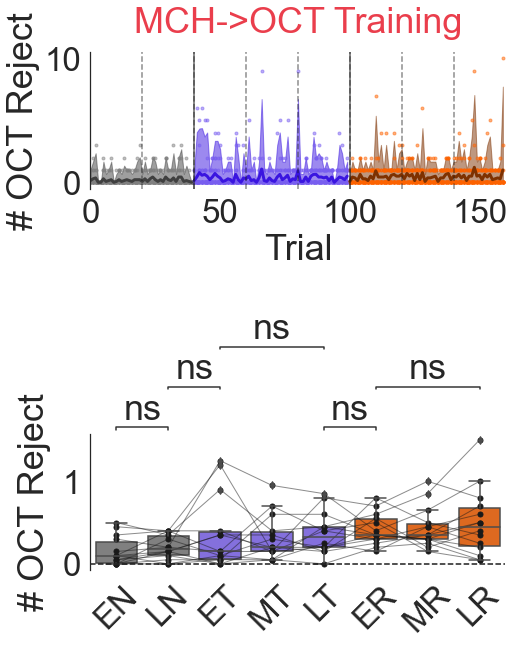

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:1.361e-01 Stat=2.000e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:7.132e-03 Stat=7.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:5.524e-01 Stat=3.700e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
ER vs. LR: Wilcoxon test (paired samples), P_val:6.763e-02 Stat=2.300e+01


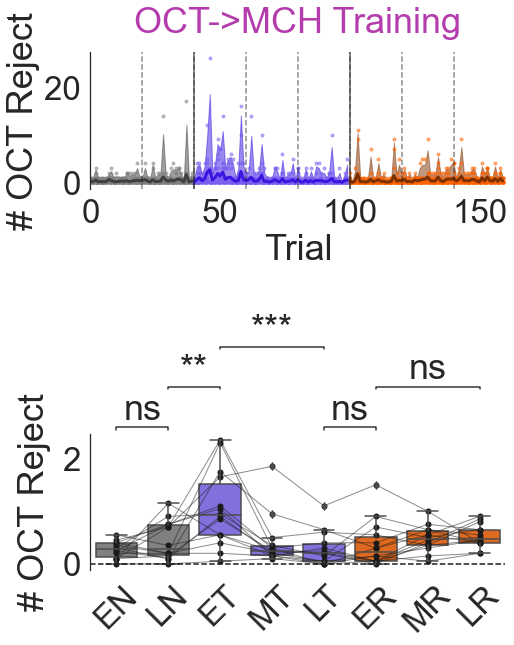

In [24]:
# get number of encounters per trial
def get_counts_per_trial(data,n_trials):
    per_trial = np.zeros(int(n_trials)+1)
    trials,counts = np.unique(data,return_counts=True)
    trials = trials.astype(int)
    per_trial[trials] = counts
    return per_trial

for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get numnber of encounters per trial
    odor_encounter_counts = np.array([get_counts_per_trial(np.clip(d['encounter_trial_number'],0,np.inf)[np.logical_and(d['encounter_odor']==1,d['encounter_decisions']!=1)],160) for d in data])

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_counts = {}
    for name, i in zip(names,range(0,160,20)):
        avg_counts[name] = [np.mean(get_counts_per_trial(np.clip(d['encounter_trial_number'],0,np.inf)[np.logical_and(d['encounter_odor']==1,d['encounter_decisions']!=1)],160)[i:i+20]) for d in data]

    df = pd.DataFrame(avg_counts)
    df = pd.melt(df,var_name='Condition',value_name='Average Number of Odor Rejections')

    sns.set(font_scale=3,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(odor_encounter_counts)):
        ax[0].plot(np.arange(0,40),odor_encounter_counts[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),odor_encounter_counts[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),odor_encounter_counts[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(odor_encounter_counts,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(odor_encounter_counts,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(odor_encounter_counts,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # add 95% percentile
    ax[0].fill_between(np.arange(0,40),np.percentile(odor_encounter_counts,2.5,axis=0)[:40],np.percentile(odor_encounter_counts,97.5,axis=0)[:40],color=change_lightness((0.5,0.5,0.5),1.5),alpha=0.5)
    ax[0].fill_between(np.arange(40,100),np.percentile(odor_encounter_counts,2.5,axis=0)[40:100],np.percentile(odor_encounter_counts,97.5,axis=0)[40:100],color=change_lightness(cmap(0.25),1.5),alpha=0.5)
    ax[0].fill_between(np.arange(100,160),np.percentile(odor_encounter_counts,2.5,axis=0)[100:160],np.percentile(odor_encounter_counts,97.5,axis=0)[100:160],color=change_lightness(cmap(0.75),1.5),alpha=0.5)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)


    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("# OCT Reject")
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y =1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_counts[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_counts[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Number of Odor Rejections',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Number of Odor Rejections')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,5])
    ax[1].set_ylabel("# OCT Reject", labelpad=12)
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    # plt.savefig(f"figures/OCT_Rejections_{alt_exp_name}.pdf",bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:2.166e-01 Stat=3.200e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:5.249e-03 Stat=1.000e+01
LT vs. ER: Wilcoxon test (paired samples), P_val:8.545e-04 Stat=4.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:6.763e-02 Stat=2.300e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:3.662e-04 Stat=2.000e+00


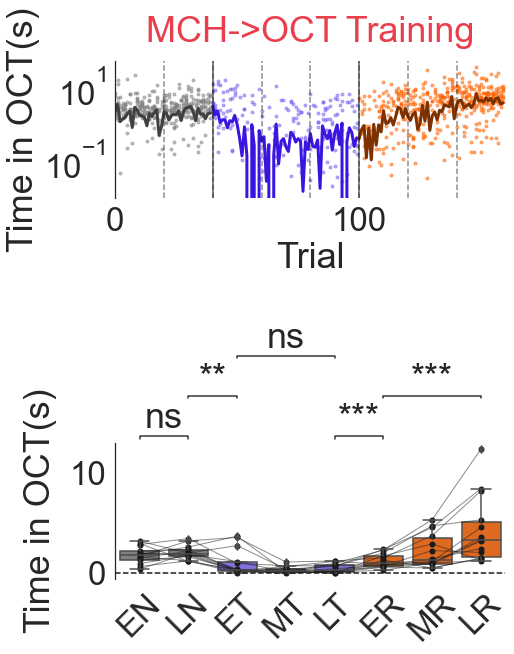

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:2.166e-01 Stat=3.200e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:2.412e-01 Stat=3.300e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:1.531e-01 Stat=2.900e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00


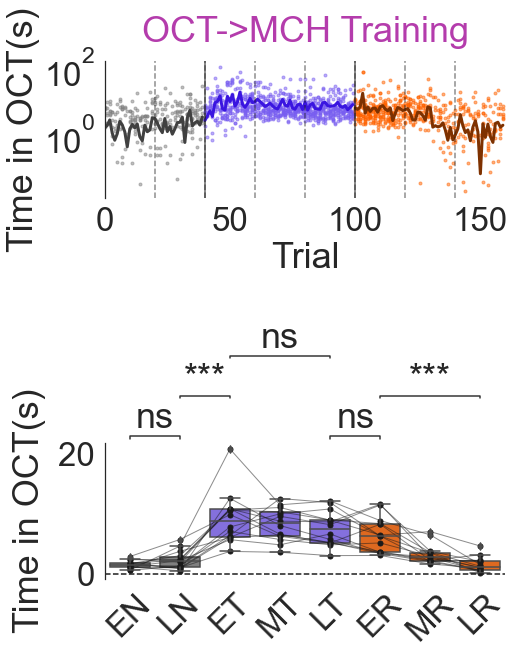

In [25]:
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get length of each trial
    length_of_trials = np.array([d['trial_odor_residence_times'][:160,1] for d in data])

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_lengths = {}
    for name, i in zip(names,range(0,160,20)):
        avg_lengths[name] = [np.mean(d['trial_odor_residence_times'][:160,1][i:i+20]) for d in data]

    df = pd.DataFrame(avg_lengths)
    df = pd.melt(df,var_name='Condition',value_name='Average Trial Length')

    sns.set(font_scale=3,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(length_of_trials)):
        ax[0].plot(np.arange(0,40),length_of_trials[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),length_of_trials[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),length_of_trials[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(length_of_trials,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(length_of_trials,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(length_of_trials,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)


    ax[0].set_yscale('log')
    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("Time in OCT(s)")
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y=1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_lengths[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_lengths[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Trial Length',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Trial Length')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,60])
    ax[1].set_ylabel("Time in OCT(s)", labelpad=12)
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    # plt.savefig(f"figures/OCT-MCH_Time_in_OCT_{alt_exp_name}.pdf", bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:2.676e-01 Stat=3.400e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.040e-01 Stat=2.600e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:4.187e-02 Stat=2.000e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:1.709e-03 Stat=6.000e+00


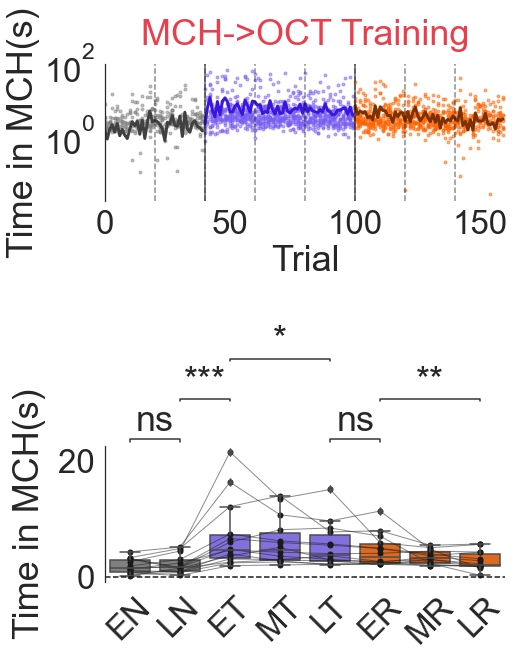

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:1.531e-01 Stat=2.900e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:6.257e-01 Stat=4.400e+01
LT vs. ER: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
ER vs. LR: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00


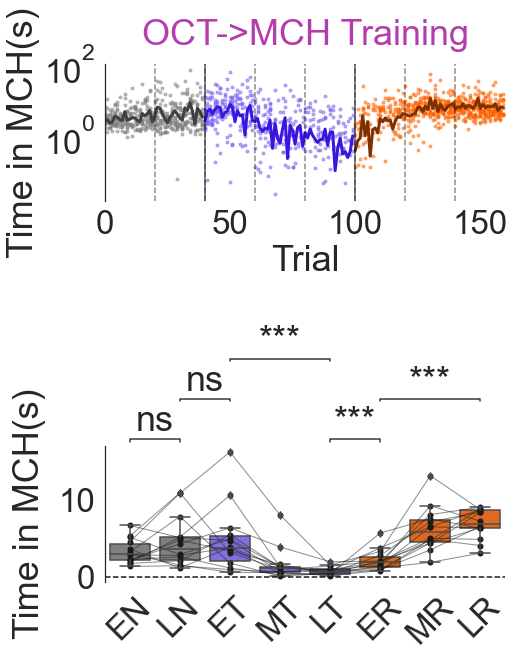

In [26]:
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get length of each trial
    length_of_trials = np.array([d['trial_odor_residence_times'][:160,2] for d in data])

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_lengths = {}
    for name, i in zip(names,range(0,160,20)):
        avg_lengths[name] = [np.mean(d['trial_odor_residence_times'][:160,2][i:i+20]) for d in data]

    df = pd.DataFrame(avg_lengths)
    df = pd.melt(df,var_name='Condition',value_name='Average Trial Length')

    sns.set(font_scale=3,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(length_of_trials)):
        ax[0].plot(np.arange(0,40),length_of_trials[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),length_of_trials[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),length_of_trials[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(length_of_trials,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(length_of_trials,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(length_of_trials,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)


    ax[0].set_yscale('log')
    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("Time in MCH(s)")
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y=1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_lengths[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_lengths[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Trial Length',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Trial Length')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,60])
    ax[1].set_ylabel("Time in MCH(s)", labelpad=12)
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    # plt.savefig(f"figures/OCT-MCH_Time_in_MCH_{alt_exp_name}.pdf", bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:6.104e-04 Stat=3.000e+00
LN vs. ET: Wilcoxon test (paired samples), P_val:2.441e-04 Stat=1.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.074e-02 Stat=1.300e+01
ET vs. LT: Wilcoxon test (paired samples), P_val:8.552e-01 Stat=4.900e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:5.798e-02 Stat=2.200e+01


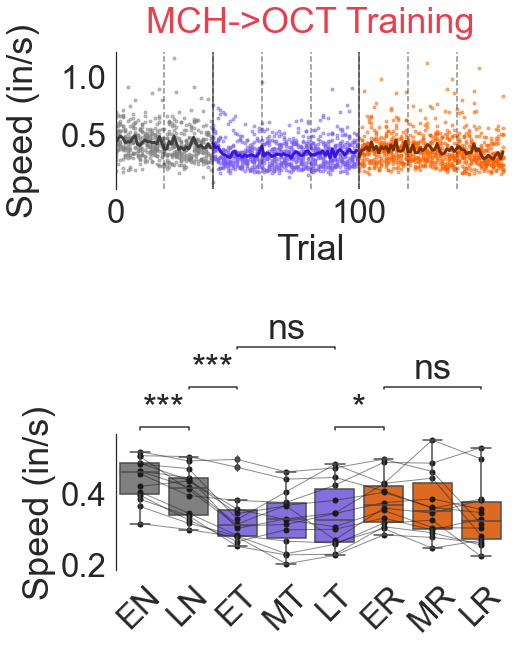

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:6.698e-01 Stat=4.500e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:4.028e-03 Stat=9.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:6.763e-02 Stat=2.300e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:4.028e-03 Stat=9.000e+00


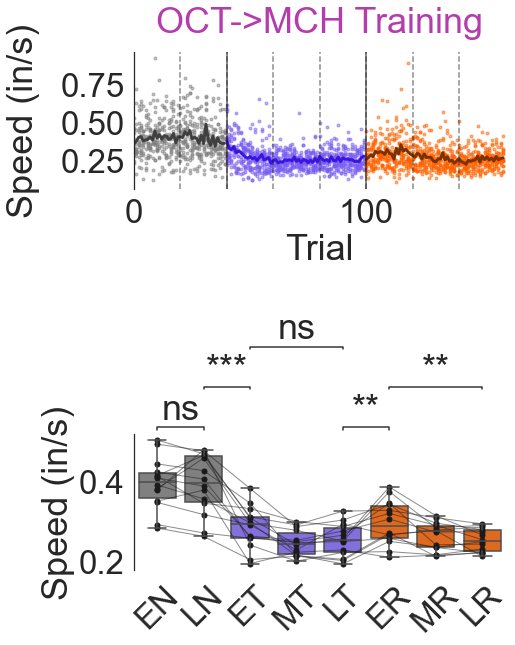

In [27]:
# get instantaenous speed per trial
def get_speed_per_trial(speed,trial):
    speed_per_trial = []
    for t in np.unique(trial):
        speed_per_trial.append(np.nanmean(speed[trial==t]))
    return np.array(speed_per_trial)

for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get length of each trial
    variable = np.array([get_speed_per_trial(d['instantaneous_speed'],d['current_encounter'][:-1])[:len(d['encounter_decisions'])][d['encounter_decisions']==1][:160] for d in data])
    

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_var = {}
    for name, i in zip(names,range(0,160,20)):
        avg_var[name] = [np.mean(get_speed_per_trial(d['instantaneous_speed'],d['current_encounter'][:-1])[:len(d['encounter_decisions'])][d['encounter_decisions']==1][i:i+20]) for d in data]

    df = pd.DataFrame(avg_var)
    df = pd.melt(df,var_name='Condition',value_name='Average Variable')

    sns.set(font_scale=3,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(variable)):
        ax[0].plot(np.arange(0,40),variable[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),variable[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),variable[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(variable,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(variable,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(variable,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)


    # ax[0].set_yscale('log')
    # ax[0].set_ylim([0.1,1])
    # ax[0].yaxis.set_major_formatter(ScalarFormatter())
    # ax[0].yaxis.set_minor_formatter(NullFormatter())
    # ax[0].set_yticks([0.2,0.6])
    # ax[0].set_yticklabels(['0.2','0.6'])
    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("Speed (in/s)", labelpad=20)
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y=1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_var[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_var[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Variable',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Variable')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,60])
    ax[1].set_ylabel("Speed (in/s)")
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    # plt.savefig(f"figures/Accept_Speed_{alt_exp_name}.pdf", bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:1.531e-01 Stat=2.900e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:5.249e-03 Stat=1.000e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:2.319e-03 Stat=7.000e+00


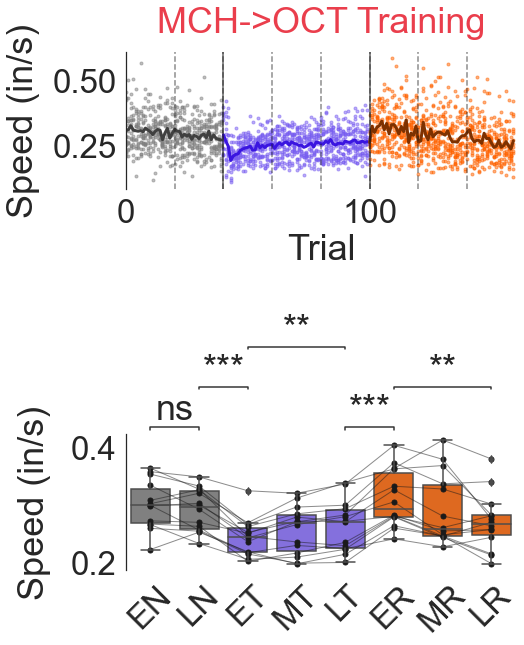

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EN vs. LN: Wilcoxon test (paired samples), P_val:1.040e-01 Stat=2.600e+01
LN vs. ET: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
LT vs. ER: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
ET vs. LT: Wilcoxon test (paired samples), P_val:5.016e-01 Stat=4.100e+01
ER vs. LR: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00


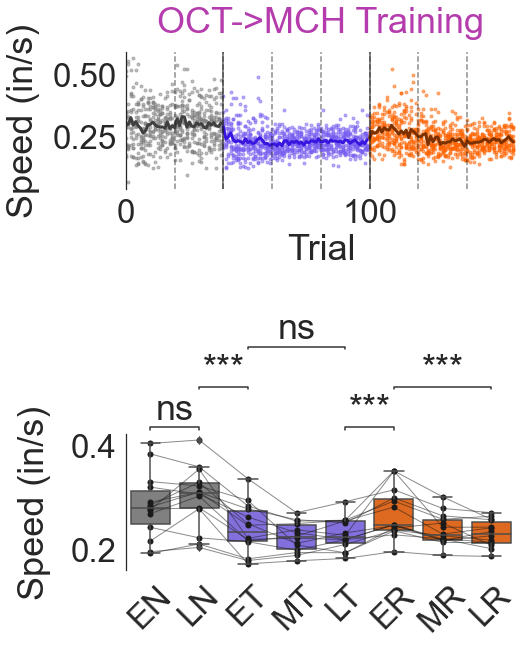

In [28]:
# get instantanenous speed per trial in specific odor
def get_speed_per_trial(speed,trial,odor,chosen_odor):
    speed_per_trial = []
    for t in np.unique(trial):
        if t>=160:
            continue
        trial_odor = chosen_odor[int(t)]
        speed_ = speed.copy()
        speed_[odor==trial_odor] = np.nan
        speed_per_trial.append(np.nanmean(speed[trial==t]))
    return np.array(speed_per_trial)

for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # get length of each trial
    variable = np.array([get_speed_per_trial(d['instantaneous_speed'],np.clip(d['current_trial'],0,np.inf),d['current_odor'],d['chosen_odor']) for d in data])
    

    names = ['EN','LN','ET','MT','LT','ER','MR','LR']
    avg_var = {}
    for name, i in zip(names,range(0,160,20)):
        avg_var[name] = [np.mean(get_speed_per_trial(d['instantaneous_speed'],d['current_trial'],d['current_odor'],d['chosen_odor'])[i:i+20]) for d in data]

    df = pd.DataFrame(avg_var)
    df = pd.melt(df,var_name='Condition',value_name='Average Variable')

    sns.set(font_scale=3,style='white')
    fig, ax = plt.subplots(2,1,figsize=(8,10))

    for i in range(len(variable)):
        ax[0].plot(np.arange(0,40),variable[i][:40], '.', color='gray', alpha=0.5)
        ax[0].plot(np.arange(40,100),variable[i][40:100], '.', color=cmap(0.25), alpha=0.5)
        ax[0].plot(np.arange(100,160),variable[i][100:160], '.', color=cmap(0.75), alpha=0.5)
        
    ax[0].plot(np.arange(0,40),np.mean(variable,axis=0)[:40], color=change_lightness((0.5,0.5,0.5),1.5), linewidth=3)
    ax[0].plot(np.arange(40,100),np.mean(variable,axis=0)[40:100], color=change_lightness(cmap(0.25),1.5), linewidth=3)
    ax[0].plot(np.arange(100,160),np.mean(variable,axis=0)[100:160], color=change_lightness(cmap(0.75),1.5), linewidth=3)

    # draw a dotted vertical line every 20 trials
    for i in range(1,8):
        ax[0].axvline(i*20, ls='--', color='k', alpha=0.5)
    
    # draw a solid vertical line at 40 and 100
    ax[0].axvline(40, ls='-', color='k', alpha=0.5, linewidth=2)
    ax[0].axvline(100, ls='-', color='k', alpha=0.5, linewidth=2)

    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("Speed (in/s)", labelpad=12)
    ax[0].set_xlim([0,160])
    ax[0].set_title(exp_name, color = cmap(0.6) if exp_name == 'MCH->OCT Training' else cmap(0.4), y=1.1)
    
    #turn off all the spines except the left
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot([0,1,2,3,4,5,6,7],[avg_var[n] for n in names], 'o', color='k', markersize=5)
    ax[1].plot([0,1,2,3,4,5,6,7],[avg_var[n] for n in names], '-', color='k', alpha=0.5, linewidth=1)
    sns.boxplot(x='Condition',y='Average Variable',data=df,ax=ax[1],palette=[(0.5,0.5,0.5,1),(0.5,0.5,0.5,1),cmap(0.25),cmap(0.25),cmap(0.25),cmap(0.75),cmap(0.75),cmap(0.75)])
    
    # add significance
    pairs = [['EN','LN'],['LN','ET'],['ET','LT'],['LT','ER'],['ER','LR']]
    annotator = Annotator(ax[1], pairs, data=df, x='Condition', y='Average Variable')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # draw horizontal lines at 0
    ax[1].axhline(0, ls='--', color='k')

    ax[1].set_xticks([0,1,2,3,4,5,6,7])
    ax[1].set_xticklabels(names, rotation=45)
    # ax[1].set_ylim([0,60])
    ax[1].set_ylabel("Speed (in/s)",labelpad=20)
    ax[1].set_xlabel("")

    #turn off all the spines except the left
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].spines['left'].set_visible(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=1.8)
    alt_exp_name = exp_name.replace(" ","_").replace("->","_")
    # plt.savefig(f"figures/Chosen_Speed_{alt_exp_name}.pdf", bbox_inches='tight')
    plt.show()